# 9 Support Vector Machines

In [1]:
import numpy

import scipy.special

import utils.project_module as pm
from utils.logger import Logger
import utils.plot as P

# restart kernel
import importlib
importlib.reload(pm)

# Initialize logger
logger = Logger("SVM")



In [2]:
inputFile = './input/trainData.txt'

logIsActive = True
save_tables = True

D, L = pm.load(inputFile)
(DTR, LTR), (DVAL, LVAL) = pm.split_db_2to1(D, L)

In [25]:
logger.__close__()

## Linear SVM Functions

In [4]:
# Optimize Linear SVM
def train_dual_SVM_linear(DTR, LTR, C, K = 1):
    
    ZTR = LTR * 2.0 - 1.0 # Convert labels to +1/-1
    DTR_EXT = numpy.vstack([DTR, numpy.ones((1,DTR.shape[1])) * K])			# x, K -> x'
    H = numpy.dot(DTR_EXT.T, DTR_EXT) * pm.vcol(ZTR) * pm.vrow(ZTR)			# H' (H'_ij = z_i * z_j * x'_i.T * x'_j)

    # Dual objective with gradient
    def fOpt(alpha):
        Ha = H @ pm.vcol(alpha)
        loss = 0.5 * (pm.vrow(alpha) @ Ha).ravel() - alpha.sum()			# L'^D(alpha) = - J'^D(alpha) = 1/2 * alpha.T * H' * alpha - alpha.T * 1
        grad = Ha.ravel() - numpy.ones(alpha.size)							# gradient of the loss
        return loss, grad

	# position of the minimum, value of the func at the minimum, information dictionary
    alphaStar, _, d = scipy.optimize.fmin_l_bfgs_b(fOpt, numpy.zeros(DTR_EXT.shape[1]), bounds = [(0, C) for _ in LTR], factr = 1.0, maxiter = 15000*1000)
    
    # Primal loss
    def primalLoss(w_hat):
        S = (pm.vrow(w_hat) @ DTR_EXT).ravel()                                                  # w'Star.T * x'_i
        return 0.5 * numpy.linalg.norm(w_hat)**2 + C * numpy.maximum(0, 1 - ZTR * S).sum()      # J' = 1/2 * ||w'Star||^2 + C * sum(max( 0, 1 - z_i*(w'Star.T * x'_i) ))

	# Compute primal solution for extended data matrix
    w_hat = (pm.vrow(alphaStar) * pm.vrow(ZTR) * DTR_EXT).sum(1)                                # w'Star = sum( alphaStar * z_i * x'_i )
    
    # Extract w and b - alternatively, we could construct the extended matrix for the samples to score and use directly v
    w, b = w_hat[0:DTR.shape[0]], w_hat[-1] * K # b must be rescaled in case K != 1, since we want to compute w'x + b * K

    primalLoss, dualLoss = primalLoss(w_hat), -fOpt(alphaStar)[0].item()
    
    if logIsActive:
        logger.log("L_BFGS_B info", lvl="INFO")
        logger.log(f"Minimum position: {alphaStar}")
        logger.log(f"Number of fun calls: {d['funcalls']}")
        logger.log()
        logger.log("Training info", lvl="INFO")
        logger.log(f"w_hat: {w_hat}")
        logger.log('primal loss %e - dual loss %e - duality gap %e' % (primalLoss, dualLoss, primalLoss - dualLoss))
        logger.log()
    
    return w, b, primalLoss, dualLoss

## Non-linear SVM Functions

In [5]:
# We create the kernel function. Since the kernel function may need additional parameters, we create a function that creates on the fly the required kernel function
# The inner function will be able to access the arguments of the outer function
def polyKernel(degree, c):
    
    def polyKernelFunc(D1, D2):
        return (numpy.dot(D1.T, D2) + c) ** degree

    return polyKernelFunc

def rbfKernel(gamma):

    def rbfKernelFunc(D1, D2):
        # Fast method to compute all pair-wise distances. Exploit the fact that |x-y|^2 = |x|^2 + |y|^2 - 2 x^T y, combined with broadcasting
        D1Norms = (D1**2).sum(0)
        D2Norms = (D2**2).sum(0)
        Z = pm.vcol(D1Norms) + pm.vrow(D2Norms) - 2 * numpy.dot(D1.T, D2)
        return numpy.exp(-gamma * Z)

    return rbfKernelFunc


# kernelFunc: function that computes the kernel matrix from two data matrices
def train_dual_SVM_kernel(DTR, LTR, C, kernelFunc, eps = 1.0):

    ZTR = LTR * 2.0 - 1.0 # Convert labels to +1/-1
    K = kernelFunc(DTR, DTR) + eps                              # k'(x_1, x_2) = k(x_1, x_2) + eps      (eps = non-linear SVM regularized bias)
    H = pm.vcol(ZTR) * pm.vrow(ZTR) * K                         # H' (H'_ij = z_i * z_j * k(x_i.T * x_j))

    # Dual objective with gradient
    def fOpt(alpha):
        Ha = H @ pm.vcol(alpha)
        loss = 0.5 * (pm.vrow(alpha) @ Ha).ravel() - alpha.sum()
        grad = Ha.ravel() - numpy.ones(alpha.size)
        return loss, grad

    alphaStar, _, d = scipy.optimize.fmin_l_bfgs_b(fOpt, numpy.zeros(DTR.shape[1]), bounds = [(0, C) for _ in LTR], factr = 1.0, maxiter = 15000*1000)
    
    if logIsActive:
        logger.log("L_BFGS_B info", lvl="INFO")
        logger.log(f"Minimum position: {alphaStar}")
        logger.log(f"Number of fun calls: {d['funcalls']}")
        logger.log()
        logger.log("Training info", lvl="INFO")
        logger.log('SVM (kernel) - C %e - dual loss %e' % (C, -fOpt(alphaStar)[0].item()))
        logger.log()

    # With non-linear SVM we are not able to compute the primal solution

    # Function to compute the scores for samples in DTE
    def fScore(DTE):
        
        K = kernelFunc(DTR, DTE) + eps
        H = pm.vcol(alphaStar) * pm.vcol(ZTR) * K                   # s(x_t)_i = alphaStar_i * z_i * k(x_i, x_t)
        return H.sum(0)                                             # s(x_t) = sum( s(x_t)_i )

    return fScore # we directly return the function to score a matrix of test samples

## Setup experiments

### Reduce training data

In [13]:
fraction = 0.4
setup = True

debug = False

if debug:
	D_exp_noRandom, L_exp_noRandom = pm.reduce_db(D, L, fraction = fraction, seed = None)

	print(D.shape)
	print(L.shape)
	print(D_exp_noRandom.shape)
	print(L_exp_noRandom.shape)

	print(f"[No random] Number of equal samples at same positions: ", numpy.sum(D[:, 0 : int(D.shape[1]*fraction)] == D_exp_noRandom) / D.shape[0] )
	print()

D_exp, L_exp = pm.reduce_db(D, L, fraction = fraction)

if debug:
	print(D.shape)
	print(L.shape)
	print(D_exp_noRandom.shape)
	print(L_exp_noRandom.shape)

	print("[Random] Number of equal samples at same positions: ", numpy.sum(D[:, 0 : int(D.shape[1]*fraction)] == D_exp) / D.shape[0] )

### Linear SVM Training

In [14]:
# Training Linear SVM using K = 1 and 11 values for C from a logarithmic scale
C = numpy.logspace(-5, 2, 13)
prior = 0.1

debug = False

if logIsActive:
    logger.log_title("[EXPERIMENTS SETUP] Traing Linear SVM")
    logger.log(f"K = 1")
    logger.log(f"C = {C.shape}")
    logger.log(C)

if setup:
    losses = []
    actDCFs = []
    minDCFs = []
    error_rates = []

    for i, c in enumerate(C):
        if logIsActive:
            logger.log_paragraph(f"{i+1}. Training Linear SVM with C = {c:.3}")
        
        w, b, primalLoss, dualLoss = train_dual_SVM_linear(D_exp, L_exp, c, debug=debug)
        losses.append((primalLoss, dualLoss))

        scores = pm.vrow(w) @ DVAL + b
        
        actDCF = pm.compute_empirical_Bayes_risk_binary_llr_optimal_decisions(scores.ravel(), LVAL, prior)
        minDCF = pm.compute_minDCF_binary_fast(scores.ravel(), LVAL, prior, returnThreshold=False)
        actDCFs.append(actDCF)
        minDCFs.append(minDCF)

        predictions = (scores > 0) * 1
        err = (predictions != LVAL).sum() / float(LVAL.size)
        error_rates.append(err)

        if logIsActive:
            logger.log("TRAINING RESULTS", lvl="INFO")
            logger.log()
            logger.log(f"actDCF: {actDCF:.3} - minDCF: {minDCF:.3}")
            logger.log(f"Error Rate: {err*100}% - Accuracy: {(1-err)*100}%")

    if logIsActive:
        logger.log_separator()
        logger.log(f"All actDCF obtained:")
        logger.log(actDCFs)
        logger.log(f"All minDCF obtained:")
        logger.log(minDCFs)
        logger.log(f"All errors obtained:")
        logger.log(error_rates)
        logger.log(f"All losses obtained:")
        logger.log(losses)

if logIsActive:
    logger.log_separator()
    logger.log("Linear SVM training completed!")
        
        

TypeError: train_dual_SVM_linear() got an unexpected keyword argument 'debug'

#### Visual results

In [ ]:
if setup:
    # plots
    pm.plot_DCFs(C, actDCFs, minDCFs, xlabel="C")

### Kernel SVM Training

#### Polynomial vs RBF Kernel

In [ ]:
C = numpy.logspace(-5, 2, 13)
prior = 0.1

# Non-linear SVM parameters
eps = 0

# Polynomial kernel parameters
degree = 2
c_kernel = 1

# RBF kernel parameters
gammas = [ numpy.exp(-(n+1)) for n in range(4)]

# kernels for training
rbfKernels = [rbfKernel(gamma) for gamma in gammas]
kernels = [polyKernel(degree, c_kernel), *rbfKernels]
k_names = ["Polynomial kernel", *[f"RBF Kernel with {'\u03B3'} = {gamma:.3}" for gamma in gammas]]

actDCFs = [[] for _ in range(len(kernels))]
minDCFs = [[] for _ in range(len(kernels))]
error_rates = [[] for _ in range(len(kernels))]

    
if logIsActive:
    logger.log_title("[EXPERIMENTS SETUP] Training non-linear SVM")
    logger.log(f"C = {C.shape}")
    logger.log(C)
    logger.log(f"Kernels: {k_names}")

if setup:
    debug = True

    # polyKernel() function test
    test = False
    if test:
        X = numpy.linspace(-5, 5, 11)

        f = polyKernel(degree, c)
        y = f(X, X)
        print(y)


    for i, kernel in enumerate(kernels):
        if logIsActive:
            logger.log_paragraph(f"{i+1}) {k_names[i]}")
        
        for j, c in enumerate(C):
            logger.log_paragraph(f"{j+1}. Training N-L SVM with C = {c}")
            fScore = train_dual_SVM_kernel(D_exp, L_exp, c, kernel, eps = eps, debug = debug)

            scores = fScore(DVAL)
            actDCF = pm.compute_empirical_Bayes_risk_binary_llr_optimal_decisions(scores.ravel(), LVAL, prior)
            minDCF = pm.compute_minDCF_binary_fast(scores.ravel(), LVAL, prior, returnThreshold=False)
            
            predictions = (scores > 0) * 1
            err = (predictions != LVAL).sum() / float(LVAL.size)
            
            actDCFs[i].append(actDCF)
            minDCFs[i].append(minDCF)
            error_rates[i].append(err)

            if logIsActive:
                logger.log("TRAINING RESULTS", lvl="INFO")
                logger.log()
                logger.log(f"actDCF: {actDCF:.3} - minDCF: {minDCF:.3}")
                logger.log(f"Error Rate: {err*100}% - Accuracy: {(1-err)*100}%")
        
        # Plot results
        pm.plot_DCFs(C, actDCFs[i], minDCFs[i], xlabel="C", title=f"N-L SVM - {k_names[i]}")

        if logIsActive:
            logger.log_separator()
            logger.log(f"All actDCF obtained:")
            logger.log(actDCFs[i])
            logger.log(f"All minDCF obtained:")
            logger.log(minDCFs[i])
            logger.log(f"All errors obtained:")
            logger.log(error_rates[i])
    
    if logIsActive:
        logger.log_separator()
        logger.log("Non-linear SVM training completed!")

## Train on the full dataset

In [6]:
#Application prior
prior = 0.1

# SVM parameters: 15 values for C from a logarithmic scale
C = numpy.logspace(-5, 2, 15)

In [7]:
def update_local_DCF(LVAL, prior, scores, actDCFs, minDCFs, error_rates, TABLE, logIsActive=False, save_tables=False):
    actDCF = pm.compute_empirical_Bayes_risk_binary_llr_optimal_decisions(scores.ravel(), LVAL, prior)
    minDCF = pm.compute_minDCF_binary_fast(scores.ravel(), LVAL, prior, returnThreshold=False)
    actDCFs.append(actDCF)
    minDCFs.append(minDCF)

    predictions = (scores > 0) * 1
    err = (predictions != LVAL).sum() / float(LVAL.size)
    error_rates.append(err*100)

    if logIsActive:
        logger.info("TRAINING RESULTS")
        logger.log()
        logger.log(f"actDCF: {actDCF:.3} - minDCF: {minDCF:.3}")
        logger.log(f"Error Rate: {err*100}% - Accuracy: {(1-err)*100}%")
    
    if save_tables:
        TABLE.append(round(actDCF, 3))
        TABLE.append(round(minDCF, 3))
        TABLE.append(round(err*100, 2))
    
    return actDCFs, minDCFs, error_rates, TABLE

def log_train_results(actDCFs, minDCFs, error_rates, losses=None):
    logger.log_separator()
    logger.log("All actDCF obtained:")
    logger.log(actDCFs)
    logger.log("All minDCF obtained:")
    logger.log(minDCFs)
    logger.log("All errors obtained:")
    logger.log(error_rates)
    if losses:
        logger.log('All losses obtained')
        logger.log(losses)

### Linear SVM

#### Training

In [8]:
# Linear SVM parameters
K = 1

# Training Linear SVM

if logIsActive:
    logger.log_title("Traing Linear SVM")
    logger.log(f"K = 1")
    logger.log(f"C = {C.shape}")
    logger.log(C.tolist())

losses = []
actDCFs = []
minDCFs = []
error_rates = []

# Table to be saved in a csv file if save_tables is true
TABLE = [ [K, c] for c in C]
HEADER = [ "K", "C", "actDCF", "minDCF", "ERROR RATE (%)"]

for i, c in enumerate(C):
    if logIsActive:
        logger.log_paragraph(f"{i+1}. Training Linear SVM with C = {c:.3}")
    
    w, b, primalLoss, dualLoss = train_dual_SVM_linear(DTR, LTR, c, K)
    losses.append((primalLoss, dualLoss))

    scores = pm.vrow(w) @ DVAL + b
    
    actDCFs, minDCFs, error_rates, TABLE[i] = update_local_DCF(LVAL, prior, scores, actDCFs, minDCFs, error_rates, TABLE[i], logIsActive, save_tables)
    
    
if logIsActive:
    log_train_results(actDCFs, minDCFs, error_rates, losses)

    logger.log_separator()
    logger.log("Linear SVM training completed!")

if save_tables:
    pm.save_csv(TABLE, HEADER, logger, "L_SVM-original_data", "outputs/L9")

#### Visual Results

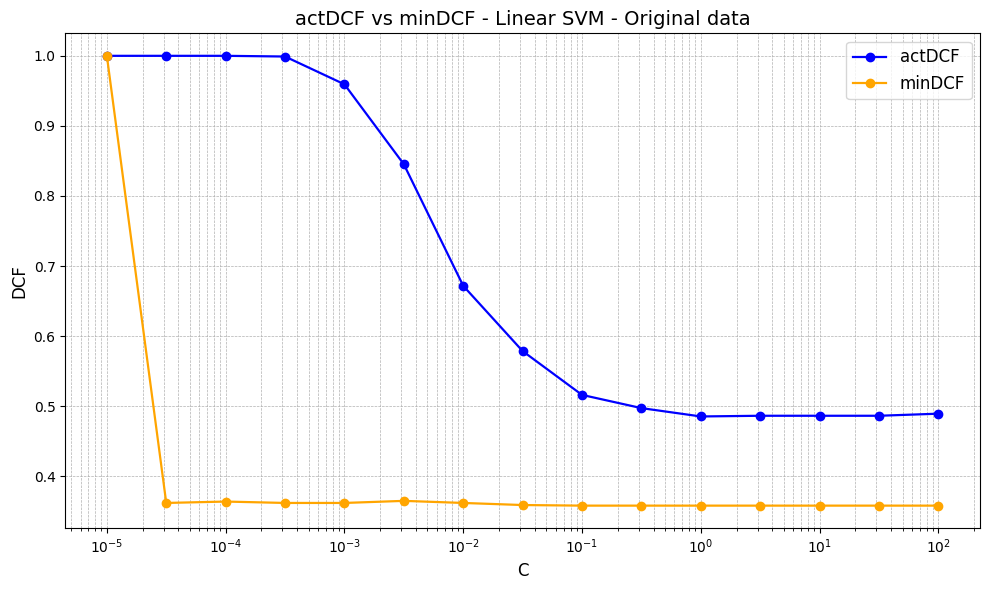

In [9]:
# plots
P.plot_log(C, actDCFs, minDCFs, f"actDCF vs minDCF - Linear SVM - Original data", "C", "DCF", "actDCF", "minDCF", save_disk=True, output_dir="./outputs/L9", output_name="DCF_L_SVM-original_data")

#### Training with centerd data

In [10]:
# center data before training
DTR_centered, DVAL_centered = pm.center_data(DTR, DVAL)

# Linear SVM parameters
K = 1

# Table to be saved in a csv file if save_tables is true
TABLE = [ [K, c] for c in C]
HEADER = [ "K", "C", "actDCF", "minDCF", "ERROR RATE (%)"]

# Linear SVM Training

if logIsActive:
    logger.log_title("Traing Linear SVM - with CENTERED DATA")
    logger.log(f"K = 1")
    logger.log(f"C = {C.shape}")
    logger.log(C.tolist())

losses = []
actDCFs = []
minDCFs = []
error_rates = []

for i, c in enumerate(C):
    if logIsActive:
        logger.log_paragraph(f"{i+1}. Training Linear SVM with C = {c:.3}")
    
    w, b, primalLoss, dualLoss = train_dual_SVM_linear(DTR_centered, LTR, c, K)
    losses.append((primalLoss, dualLoss))

    scores = pm.vrow(w) @ DVAL_centered + b

    actDCFs, minDCFs, error_rates, TABLE[i] = update_local_DCF(LVAL, prior, scores, actDCFs, minDCFs, error_rates, TABLE[i], logIsActive, save_tables)
    
    
if logIsActive:
    log_train_results(actDCFs, minDCFs, error_rates, losses)
    
    logger.log_separator()
    logger.log("Linear SVM training (with CENTERED DATA) completed!")

if save_tables:
    pm.save_csv(TABLE, HEADER, logger, "L_SVM-centered_data", "outputs/L9")

#### Visual Results

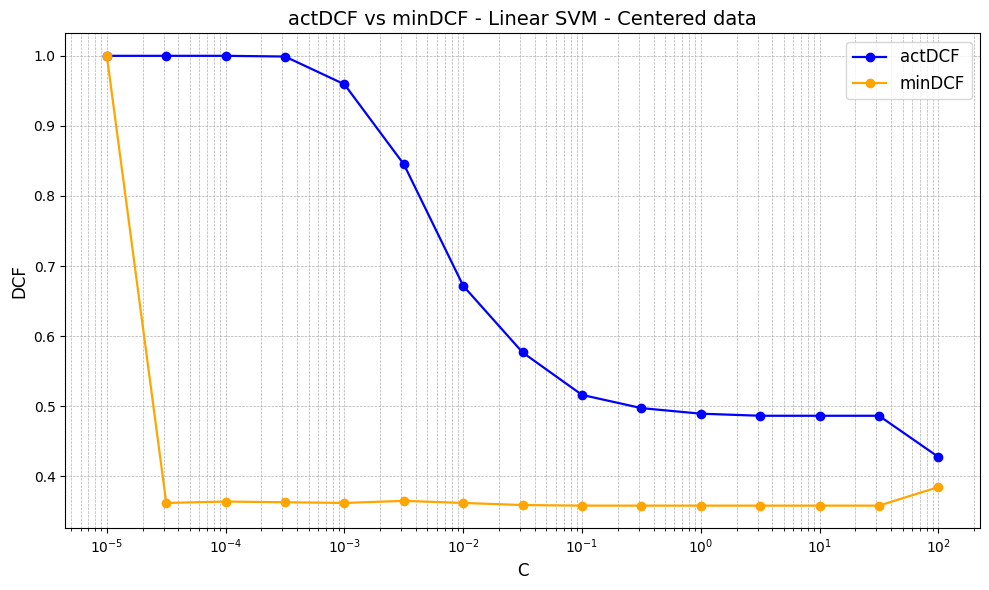

In [11]:
# plots
P.plot_log(C, actDCFs, minDCFs, f"actDCF vs minDCF - Linear SVM - Centered data", "C", "DCF", "actDCF", "minDCF", save_disk=True, output_dir="./outputs/L9", output_name="DCF_L_SVM-centered_data")

#### Why centered data do not affect results?

In [ ]:
# see the differences in distributions
P.plot_hist_DR(DTR, DVAL_centered, 6, "Original data vs centered data")

### Non-linear SVM

#### Polynomial (d=2) kernel

In [12]:
# Non-linear SVM parameters
eps = 0

# Polynomial kernel parameters
degree = 2
c_kernel = 1

kernel = polyKernel(degree, c_kernel)

actDCFs = []
minDCFs = []
error_rates = []

# Table to be saved in a csv file if save_tables is true
TABLE = [ [eps, degree, c] for c in C]
HEADER = [ "ξ", "d", "C", "actDCF", "minDCF", "ERROR RATE (%)"]
    
if logIsActive:
    logger.log_title(f"Training non-linear SVM - POLYNOMIAL kernel")
    logger.log(f"C = {C.shape}")
    logger.log(C.tolist())
    logger.log(f"ξ: {eps} - Kernel degree: {degree} - C (kernel): {c_kernel}")

for i, c in enumerate(C):
    logger.log_paragraph(f"{i+1}. Training N-L SVM with C = {c}")
    fScore = train_dual_SVM_kernel(DTR, LTR, c, kernel, eps = eps)

    scores = fScore(DVAL)

    actDCFs, minDCFs, error_rates, TABLE[i] = update_local_DCF(LVAL, prior, scores, actDCFs, minDCFs, error_rates, TABLE[i], logIsActive, save_tables)
    
    
if logIsActive:
    log_train_results(actDCFs, minDCFs, error_rates)

    logger.log_separator()
    logger.log("Non-linear SVM training (with Polynomial d=2 kernel) completed!")

if save_tables:
    pm.save_csv(TABLE, HEADER, logger, "NL_SVM-poly_d2", "outputs/L9")

##### Visual results

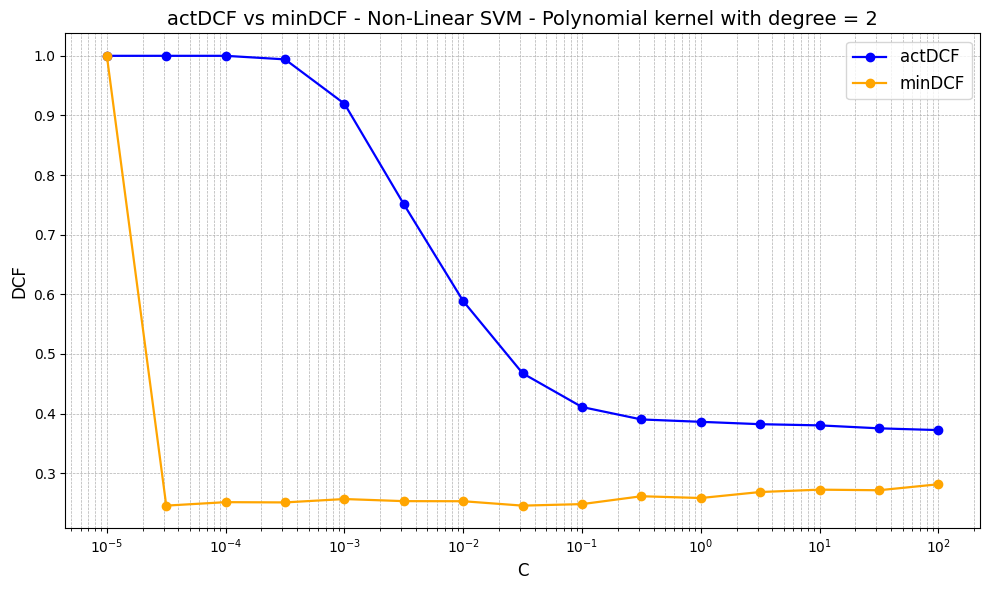

In [13]:
# Plot results
P.plot_log(C, actDCFs, minDCFs, f"actDCF vs minDCF - Non-Linear SVM - Polynomial kernel with degree = 2", "C", "DCF", "actDCF", "minDCF", save_disk=True, output_dir="./outputs/L9", output_name="DCF_NL_SVM-poly_d2")

#### RBF kernel

In [14]:
# Non-linear SVM parameters
eps = 1

# RBF kernel parameters
gammas = [ numpy.exp(-(n+1)) for n in range(4)]

# kernels for training
kernels = [rbfKernel(gamma) for gamma in gammas]
k_names = [f"RBF Kernel with γ = {gamma:.3}" for gamma in gammas]

actDCFs = [[] for _ in range(len(kernels))]
minDCFs = [[] for _ in range(len(kernels))]
error_rates = [[] for _ in range(len(kernels))]

# Table to be saved in a csv file if save_tables is true
gammas_strings = [f"exp(-{n+1})" for n in range(4)]
TABLE = [ [eps, gamma, c] for gamma in gammas_strings for c in C ]
HEADER = [ "ξ", "γ", "C", "actDCF", "minDCF", "ERROR RATE (%)" ]
    
if logIsActive:
    logger.log_title("Training non-linear SVM - RBF kernels")
    logger.log(f"C = {C.shape}")
    logger.log(C.tolist())
    logger.log(f"ξ: {eps}")
    logger.log(f"Kernels: {k_names}")

for i, kernel in enumerate(kernels):
    if logIsActive:
        logger.log_paragraph(f"{i+1}) {k_names[i]}")
    
    for j, c in enumerate(C):
        logger.log_paragraph(f"{j+1}. Training N-L SVM with C = {c}")
        fScore = train_dual_SVM_kernel(DTR, LTR, c, kernel, eps = eps)

        scores = fScore(DVAL)

        actDCFs[i], minDCFs[i], error_rates[i], TABLE[(i*len(C))+j] = update_local_DCF(LVAL, prior, scores, actDCFs[i], minDCFs[i], error_rates[i], TABLE[(i*len(C))+j], logIsActive, save_tables)
        

    if logIsActive:
        log_train_results(actDCFs[i], minDCFs[i], error_rates[i])


if logIsActive:
    logger.log_separator()
    logger.log("Non-linear SVM training (with RBF kernel) completed!")

if save_tables:
    pm.save_csv(TABLE, HEADER, logger, "NL_SVM-RBF", "outputs/L9")

##### Visual results

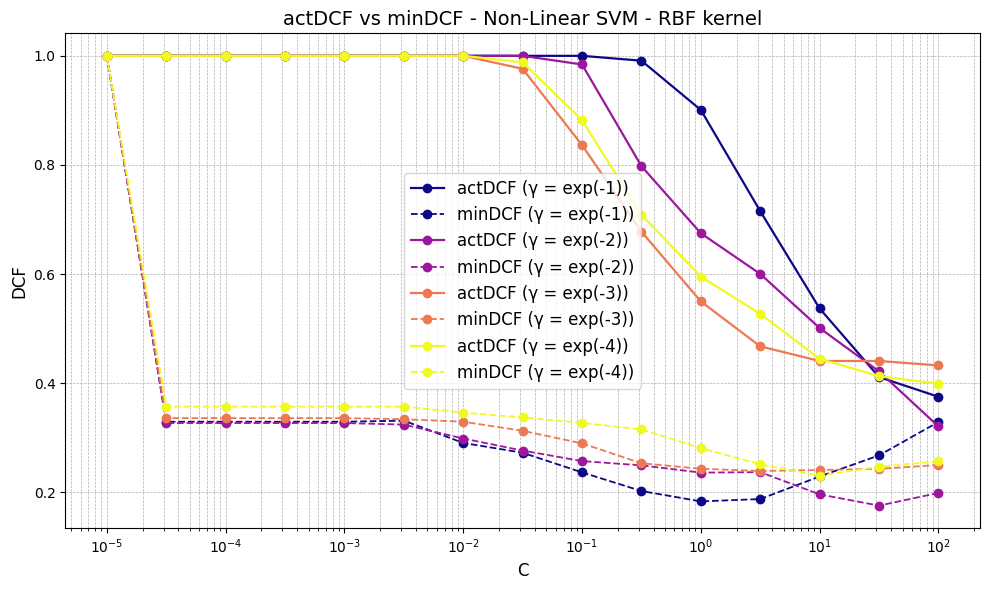

In [15]:
# Plot results
labels0 = [ f"actDCF (γ = {gamma})" for gamma in gammas_strings]
labels1 = [ f"minDCF (γ = {gamma})" for gamma in gammas_strings]
P.plot_log(C, actDCFs, minDCFs, f"actDCF vs minDCF - Non-Linear SVM - RBF kernel", "C", "DCF", labels0, labels1, save_disk=True, output_dir="./outputs/L9", output_name="DCF_NL_SVM-RBF")

#### Polynomial (d=4)

In [16]:
# Non-linear SVM parameters
eps = 0

# Polynomial kernel parameters
degree = 4
c_kernel = 1

kernel = polyKernel(degree, c_kernel)

actDCFs = []
minDCFs = []
error_rates = []

# Table to be saved in a csv file if save_tables is true
TABLE = [ [eps, degree, c] for c in C]
HEADER = [ "ξ", "d", "C", "actDCF", "minDCF", "ERROR RATE (%)"]
    
if logIsActive:
    logger.log_title(f"Training non-linear SVM - POLYNOMIAL kernel")
    logger.log(f"C = {C.shape}")
    logger.log(C.tolist())
    logger.log(f"ξ: {eps} - Kernel degree: {degree} - C (kernel): {c_kernel}")

for i, c in enumerate(C):
    logger.log_paragraph(f"{i+1}. Training N-L SVM with C = {c}")
    fScore = train_dual_SVM_kernel(DTR, LTR, c, kernel, eps = eps)

    scores = fScore(DVAL)
    actDCFs, minDCFs, error_rates, TABLE[i] = update_local_DCF(LVAL, prior, scores, actDCFs, minDCFs, error_rates, TABLE[i], logIsActive, save_tables)
    
    
if logIsActive:
    log_train_results(actDCFs, minDCFs, error_rates)

    logger.log_separator()
    logger.log("Non-linear SVM training (with Polynomial d=4 kernel) completed!")

if save_tables:
    pm.save_csv(TABLE, HEADER, logger, "NL_SVM-poly_d4", "outputs/L9")

##### Visual results

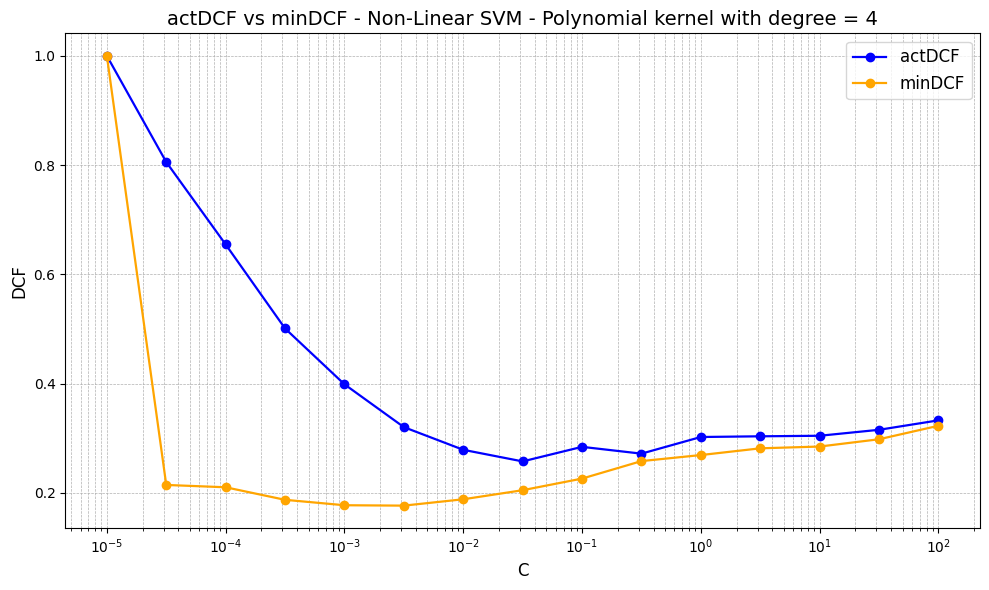

In [17]:
# Plot results
P.plot_log(C, actDCFs, minDCFs, f"actDCF vs minDCF - Non-Linear SVM - Polynomial kernel with degree = 4", "C", "DCF", "actDCF", "minDCF", save_disk=True, output_dir="./outputs/L9", output_name="DCF_NL_SVM-poly_d4")

# Lab end

In [19]:
logger.__close__()